In [110]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [111]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [112]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [113]:
batch_size = 32
img_height = 180
img_width = 180

In [114]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=23,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [115]:
val_test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [116]:
val_batches = tf.data.experimental.cardinality(val_test_ds)
print(val_batches)

tf.Tensor(23, shape=(), dtype=int64)


In [117]:
val_ds = val_test_ds.take(val_batches // 5)
test_ds = val_test_ds.take(val_batches // 5)

In [118]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


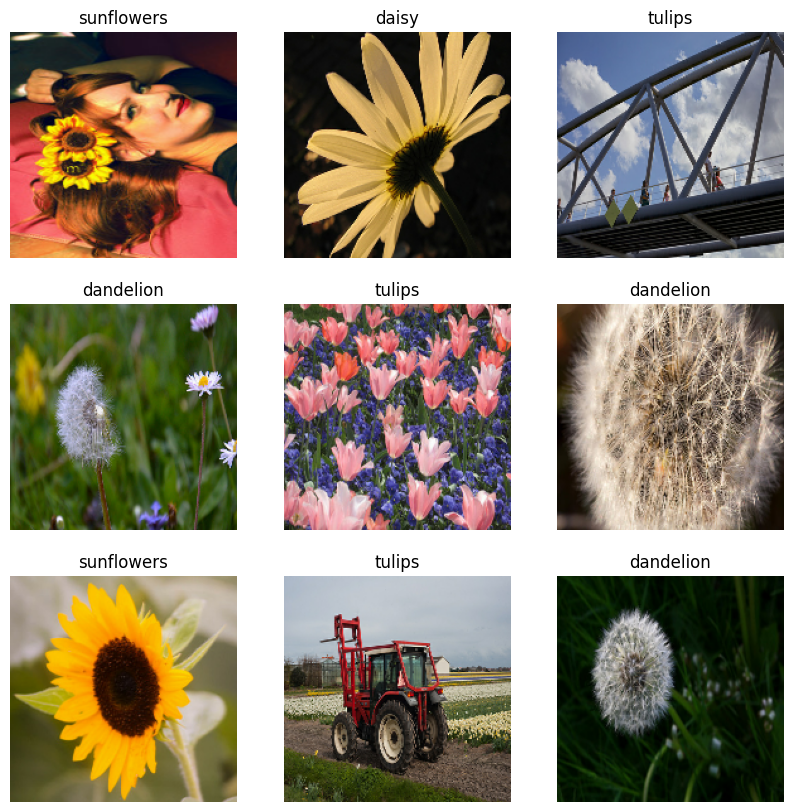

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [120]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [127]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [128]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.DepthwiseConv2D((16, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.DepthwiseConv2D((32, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.DepthwiseConv2D((64, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [129]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [130]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 depthwise_conv2d_29 (Depth  (None, 180, 180, 3)       147       
 wiseConv2D)                                                     
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 90, 90, 3)         0         
 ng2D)                                                           
                                                                 
 depthwise_conv2d_30 (Depth  (None, 90, 90, 3)         291       
 wiseConv2D)                                                     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 45, 45, 3)         0         
 ng2D)                                               

In [131]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [132]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


92/92 [==============================] - 4s 42ms/step - loss: 1.4865 - accuracy: 0.3546 - val_loss: 1.3830 - val_accuracy: 0.4219
Epoch 2/20
92/92 [==============================] - 4s 41ms/step - loss: 1.2455 - accuracy: 0.4871 - val_loss: 1.1695 - val_accuracy: 0.5078
Epoch 3/20
92/92 [==============================] - 4s 39ms/step - loss: 1.1562 - accuracy: 0.5351 - val_loss: 1.0697 - val_accuracy: 0.5312
Epoch 4/20
92/92 [==============================] - 4s 38ms/step - loss: 1.0784 - accuracy: 0.5766 - val_loss: 1.0201 - val_accuracy: 0.5547
Epoch 5/20
92/92 [==============================] - 4s 39ms/step - loss: 0.9946 - accuracy: 0.6076 - val_loss: 0.9151 - val_accuracy: 0.6016
Epoch 6/20
92/92 [==============================] - 4s 39ms/step - loss: 0.9338 - accuracy: 0.6396 - val_loss: 0.9494 - val_accuracy: 0.6484
Epoch 7/20
92/92 [==============================] - 4s 39ms/step - loss: 0.8655 - accuracy: 0.6679 - val_loss: 0.8096 - val_accuracy: 0.6953
Epoch 8/20
92/92 [======

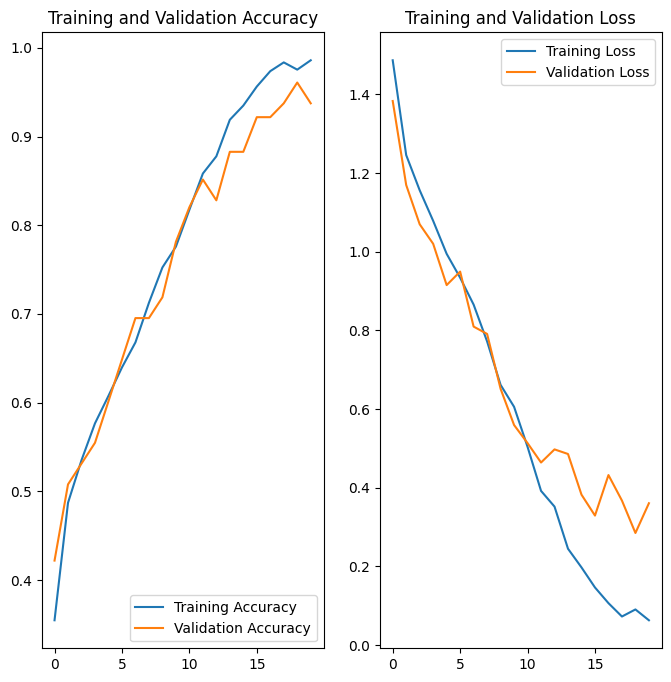

In [133]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 74ms/step
This image most likely belongs to tulips with a 99.57 percent confidence.


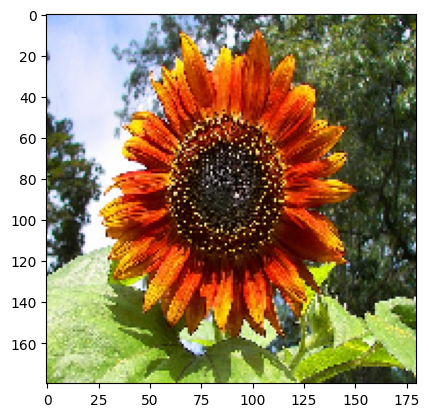

In [134]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


plt.imshow(img_array[0].numpy().astype("uint8"))
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [135]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 [==============================] - 0s 19ms/step - loss: 0.7035 - accuracy: 0.8828
Test accuracy : 0.8828125


### Apply data augmentation

In [136]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

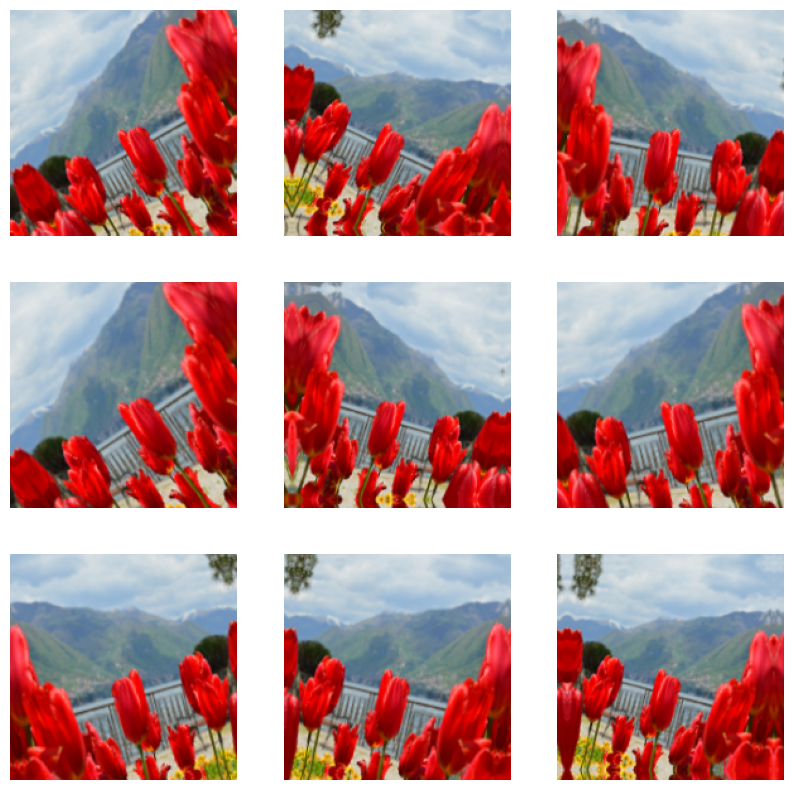

In [137]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [138]:
modelDA = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.DepthwiseConv2D((16, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.DepthwiseConv2D((32, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.DepthwiseConv2D((64, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [139]:
modelDA.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [140]:
modelDA.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_16 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 depthwise_conv2d_32 (Depth  (None, 180, 180, 3)       147       
 wiseConv2D)                                                     
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 90, 90, 3)         0         
 ng2D)                                                           
                                                                 
 depthwise_conv2d_33 (Depth  (None, 90, 90, 3)         291       
 wiseConv2D)                                                     
                                                     

In [141]:
epochs = 20
history = modelDA.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 7s 59ms/step - loss: 1.4740 - accuracy: 0.3525 - val_loss: 1.4109 - val_accuracy: 0.4141
Epoch 2/20
92/92 [==============================] - 6s 61ms/step - loss: 1.3739 - accuracy: 0.4193 - val_loss: 1.3118 - val_accuracy: 0.4766
Epoch 3/20
92/92 [==============================] - 5s 58ms/step - loss: 1.2976 - accuracy: 0.4567 - val_loss: 1.2775 - val_accuracy: 0.4453
Epoch 4/20
92/92 [==============================] - 5s 58ms/step - loss: 1.2678 - accuracy: 0.4745 - val_loss: 1.2251 - val_accuracy: 0.5312
Epoch 5/20
92/92 [==============================] - 5s 58ms/step - loss: 1.2492 - accuracy: 0.4823 - val_loss: 1.1889 - val_accuracy: 0.5391
Epoch 6/20
92/92 [==============================] - 5s 58ms/step - loss: 1.2539 - accuracy: 0.4860 - val_loss: 1.1438 - val_accuracy: 0.5547
Epoch 7/20
92/92 [==============================] - 5s 58ms/step - loss: 1.1951 - accuracy: 0.5109 - val_loss: 1.1400 - val_accuracy: 0.5312
Epoch 8/20
92

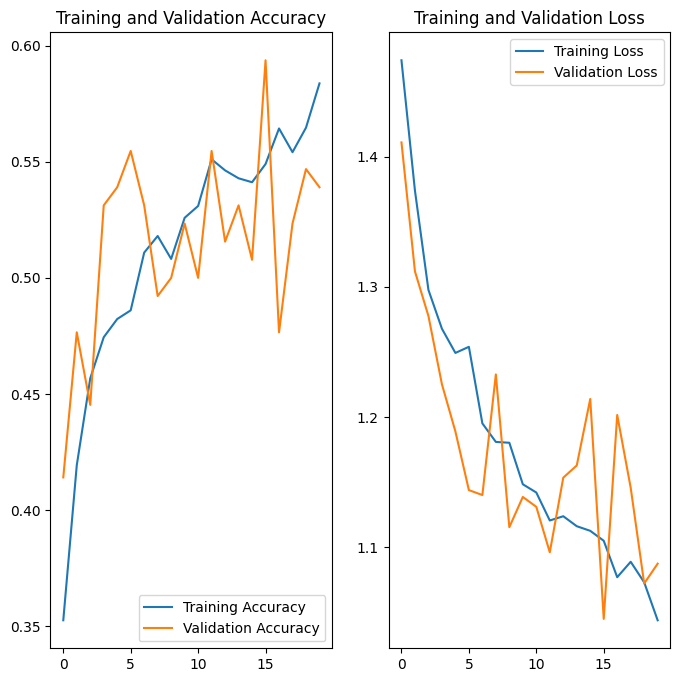

In [142]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 61ms/step
This image most likely belongs to sunflowers with a 43.58 percent confidence.


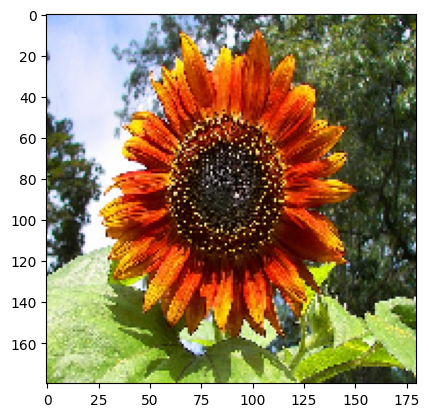

In [143]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = modelDA.predict(img_array)
score = tf.nn.softmax(predictions[0])


plt.imshow(img_array[0].numpy().astype("uint8"))
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [144]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 [==============================] - 0s 17ms/step - loss: 0.4286 - accuracy: 0.9219
Test accuracy : 0.921875


### Non-depthwise convolution

In [145]:
modelNDW = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [146]:
modelNDW.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [147]:
modelNDW.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_17 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

In [148]:
epochs = 20
history = modelNDW.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 12s 125ms/step - loss: 1.2515 - accuracy: 0.4779 - val_loss: 0.9590 - val_accuracy: 0.6328
Epoch 2/20
92/92 [==============================] - 12s 126ms/step - loss: 0.9834 - accuracy: 0.6155 - val_loss: 0.9817 - val_accuracy: 0.6094
Epoch 3/20
92/92 [==============================] - 12s 128ms/step - loss: 0.8872 - accuracy: 0.6553 - val_loss: 0.8185 - val_accuracy: 0.6797
Epoch 4/20
92/92 [==============================] - 11s 122ms/step - loss: 0.8013 - accuracy: 0.6829 - val_loss: 0.7141 - val_accuracy: 0.6797
Epoch 5/20
92/92 [==============================] - 12s 134ms/step - loss: 0.7453 - accuracy: 0.7091 - val_loss: 0.7988 - val_accuracy: 0.6562
Epoch 6/20
92/92 [==============================] - 12s 132ms/step - loss: 0.7109 - accuracy: 0.7262 - val_loss: 0.7472 - val_accuracy: 0.6797
Epoch 7/20
92/92 [==============================] - 12s 133ms/step - loss: 0.6784 - accuracy: 0.7354 - val_loss: 0.8668 - val_accuracy: 0.6953

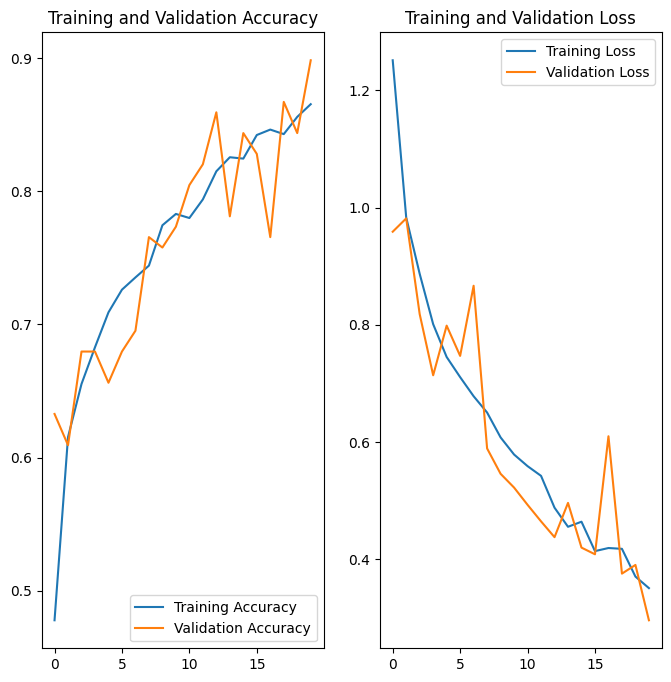

In [149]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 55ms/step
This image most likely belongs to sunflowers with a 87.79 percent confidence.


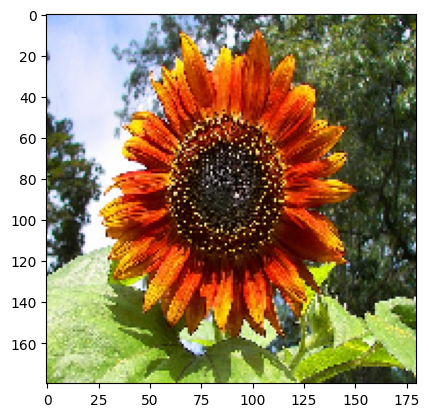

In [150]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = modelNDW.predict(img_array)
score = tf.nn.softmax(predictions[0])


plt.imshow(img_array[0].numpy().astype("uint8"))
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [151]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 [==============================] - 0s 19ms/step - loss: 0.7138 - accuracy: 0.8984
Test accuracy : 0.8984375
